In [1]:
import json
import pandas as pd
import numpy as np
import networkx as nx
import jellyfish
import os
import shutil
import subprocess
import requests
from github import Github
from git import Repo
from scipy.cluster.hierarchy import dendrogram, linkage
from matplotlib import pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score
from sklearn import preprocessing
from sklearn.cluster import AgglomerativeClustering
from zipfile import ZipFile
from filecmp import dircmp
import configparser
import h2o
import scipy as sp

## Result Gathering

In [2]:
main_df = None
directory = "Effort_Estimation_Results_3E_v2/"
for filename in os.listdir(directory):
    print(filename)
    if main_df is None:
        main_df = pd.read_csv(os.path.join(directory, filename))
        main_df['project_name'] = filename.replace('.csv', '')
    else:
        temp_df = pd.read_csv(os.path.join(directory, filename))
        temp_df['project_name'] = filename.replace('.csv', '')
        frames = [main_df, temp_df]
        main_df = pd.concat(frames)

Alluxio.csv
Assertj-core.csv
Atmosphere.csv
AxonFramework.csv
Beam.csv
Byte-buddy.csv
Camel.csv
Cas.csv
Cassandra.csv
Cxf.csv
Dbeaver.csv
Eclim.csv
Guacamole-client.csv
Hadoop.csv
Hawtio.csv
karaf.csv
Okhttp.csv
Openapi-generator.csv
Orientdb.csv
Redisson.csv
Rest-assured.csv
Spring-framework.csv
Spring-security.csv
Storm.csv
Tika.csv
Traccar.csv


In [3]:
main_df.head()

,kmean_label,time_taken_mean,time_taken_min,time_taken_max,time_taken_q10,time_taken_q20,time_taken_q25,time_taken_q30,time_taken_q40,time_taken_q50,...,actual_num_of_classes_touched_min,actual_num_of_classes_touched_max,actual_num_of_classes_touched_std,commit_line_changed,refactoring_perc,refactoring_perc_time_taken,cocomoII_time_taken,geneticP_time_taken,softwareMaintenance_time_taken,fuzzy_time_taken
0,5,12.712987,1.0,166.0,1.0,1.0,2.0,2.0,3.0,5.0,...,2,2,NaN,8,1.000000,15.00000,4.13952,2.477916,12.48,42.435515
1,5,12.712987,1.0,166.0,1.0,1.0,2.0,2.0,3.0,5.0,...,1,1,NaN,346,0.225434,1.00000,179.03424,107.076009,2229.76,519.589347
2,5,12.712987,1.0,166.0,1.0,1.0,2.0,2.0,3.0,5.0,...,1,2,0.707107,35,1.000000,1.00000,18.11040,10.840124,189.60,113.234791
3,5,12.712987,1.0,166.0,1.0,1.0,2.0,2.0,3.0,5.0,...,1,13,4.018895,194,0.185567,3.71134,100.38336,60.060503,1232.64,353.641141
4,5,12.712987,1.0,166.0,1.0,1.0,2.0,2.0,3.0,5.0,...,1,136,50.585661,1938,0.004128,1.00000,1002.79872,597.273303,12673.28,1634.048307


In [4]:
for column in main_df:
    print(column)

kmean_label
time_taken_mean
time_taken_min
time_taken_max
time_taken_q10
time_taken_q20
time_taken_q25
time_taken_q30
time_taken_q40
time_taken_q50
time_taken_q60
time_taken_q70
time_taken_q75
time_taken_q80
time_taken_q90
sha
name
email
date
login
message
parent_sha
parent_date
time_taken
contains_refactoring
project_name
commit_compared_with
cbo_mean
cbo_min
cbo_max
cbo_std
wmc_mean
wmc_min
wmc_max
wmc_std
dit_mean
dit_min
dit_max
dit_std
rfc_mean
rfc_min
rfc_max
rfc_std
lcom_mean
lcom_min
lcom_max
lcom_std
totalMethods_mean
totalMethods_min
totalMethods_max
totalMethods_std
staticMethods_mean
staticMethods_min
staticMethods_max
staticMethods_std
publicMethods_mean
publicMethods_min
publicMethods_max
publicMethods_std
privateMethods_mean
privateMethods_min
privateMethods_max
privateMethods_std
protectedMethods_mean
protectedMethods_min
protectedMethods_max
protectedMethods_std
defaultMethods_mean
defaultMethods_min
defaultMethods_max
defaultMethods_std
abstractMethods_mean
abstractMe

In [5]:
len(main_df)

775

In [6]:
main_df['refactoring_perc_time_taken'] = main_df['refactoring_perc'] * main_df['time_taken']

In [7]:
def plotGraph(y_test,y_pred,y_test_str,y_pred_str,regressorName):
    if max(y_test) >= max(y_pred):
        my_range = int(max(y_test))
    else:
        my_range = int(max(y_pred))
        
    plt.figure(figsize=(15,15))
    plt.scatter(range(len(y_test)), y_test, color='blue', label=y_test_str)
    plt.scatter(range(len(y_pred)), y_pred, color='red', label=y_pred_str)
    plt.title(regressorName)
    plt.legend(loc="upper left")
    plt.show()
    return

def plotGraphandSave(y_test,y_pred,y_test_str,y_pred_str,regressorName,img_name):
    if max(y_test) >= max(y_pred):
        my_range = int(max(y_test))
    else:
        my_range = int(max(y_pred))
        
    plt.figure(figsize=(15,15))
    plt.scatter(range(len(y_test)), y_test, color='blue', label=y_test_str)
    plt.scatter(range(len(y_pred)), y_pred, color='red', label=y_pred_str)
    plt.title(regressorName)
    plt.legend(loc="upper left")
    plt.savefig(f'model_prediction_images/{img_name}.png')
    plt.show()
    return





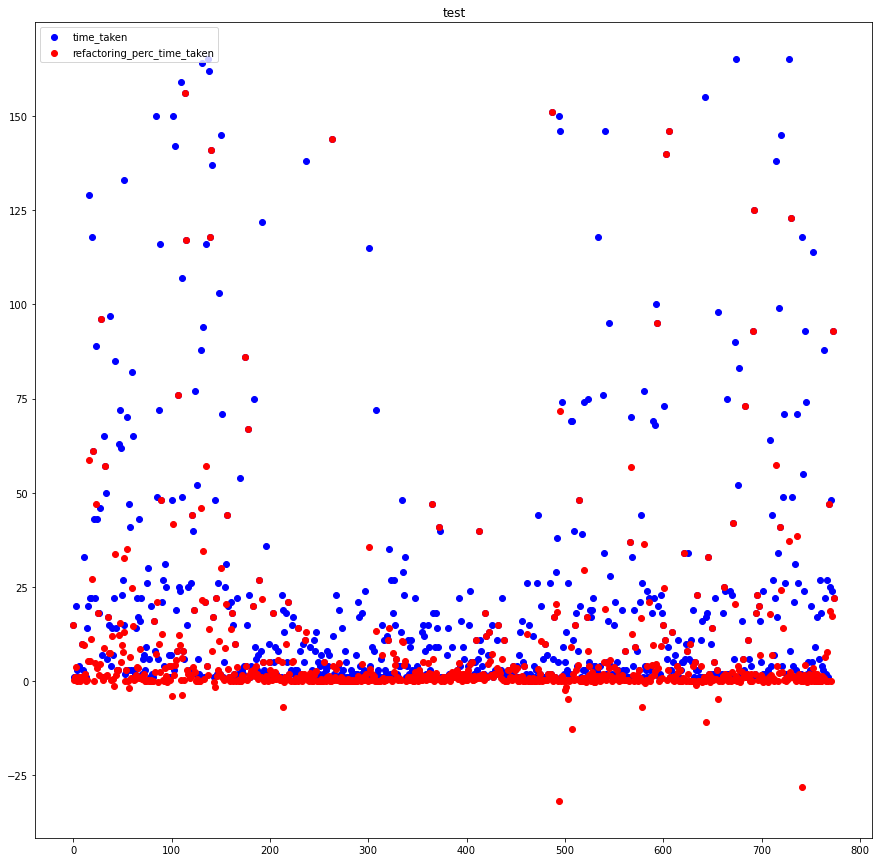

In [8]:
plotGraph(main_df['time_taken'], main_df['refactoring_perc_time_taken'],'time_taken','refactoring_perc_time_taken','test')

In [9]:
main_df = main_df[main_df['refactoring_perc_time_taken'] > 0]
#main_df = main_df[main_df['refactoring_perc_time_taken'] <= 8]
#main_df = main_df[main_df['refactoring_perc_time_taken'] <= 20]

#main_df = main_df[main_df['time_taken_final'] <= 60]
#main_df = main_df[main_df['time_taken_final'] > 2]

In [10]:
main_df['refactoring_perc_time_taken'].value_counts()

1.000000     27
2.000000     23
3.000000     11
4.000000      6
5.000000      6
             ..
0.008475      1
0.093458      1
32.716578     1
0.434164      1
0.213873      1
Name: refactoring_perc_time_taken, Length: 629, dtype: int64

In [11]:
def get_final_time_taken(row):
    if row['time_taken'] > row['time_taken_q90']:
        return row['time_taken'] - row['time_taken_q90']
    elif row['time_taken'] > row['time_taken_q80']:
        return row['time_taken'] - row['time_taken_q80']
    elif row['time_taken'] > row['time_taken_q60']:
        return row['time_taken'] - row['time_taken_q60']
    elif row['time_taken'] > row['time_taken_q40']:
        return row['time_taken'] - row['time_taken_q40']
    elif row['time_taken'] > row['time_taken_q20']:
        return row['time_taken'] - row['time_taken_q20']

In [12]:
main_df['time_taken_final'] = main_df.apply(lambda row: get_final_time_taken(row), axis=1)



In [13]:
#plotGraph(main_df['time_taken_final'], main_df['time_taken_mean'],' test')

{'whiskers': [<matplotlib.lines.Line2D at 0x1915f6240b8>,
 'caps': [<matplotlib.lines.Line2D at 0x1915f6247b8>,
 'boxes': [<matplotlib.lines.Line2D at 0x1915f631f28>],
 'medians': [<matplotlib.lines.Line2D at 0x1915f624eb8>],
 'fliers': [<matplotlib.lines.Line2D at 0x1915f61f278>],
 'means': []}

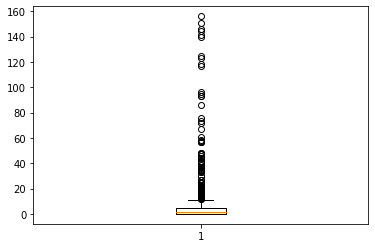

In [14]:
plt.boxplot(main_df['refactoring_perc_time_taken'])

{'whiskers': [<matplotlib.lines.Line2D at 0x1915c0d8390>,
 'caps': [<matplotlib.lines.Line2D at 0x1915c0d8a90>,
 'boxes': [<matplotlib.lines.Line2D at 0x1915c0d8240>],
 'medians': [<matplotlib.lines.Line2D at 0x1915c0e21d0>],
 'fliers': [<matplotlib.lines.Line2D at 0x1915c0e2550>],
 'means': []}

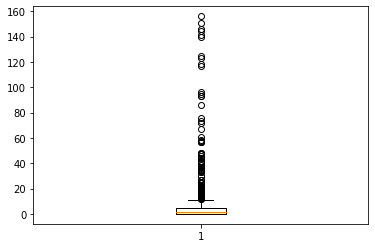

In [15]:
plt.boxplot(main_df['refactoring_perc_time_taken'])

In [16]:
main_df['time_taken_final'].value_counts()

1.0     137
2.0      73
6.0      35
4.0      33
3.0      32
       ... 
0.6       1
2.4       1
1.2       1
10.6      1
32.7      1
Name: time_taken_final, Length: 119, dtype: int64

In [17]:
main_df = main_df.fillna(0)

In [18]:
main_df

,kmean_label,time_taken_mean,time_taken_min,time_taken_max,time_taken_q10,time_taken_q20,time_taken_q25,time_taken_q30,time_taken_q40,time_taken_q50,...,actual_num_of_classes_touched_max,actual_num_of_classes_touched_std,commit_line_changed,refactoring_perc,refactoring_perc_time_taken,cocomoII_time_taken,geneticP_time_taken,softwareMaintenance_time_taken,fuzzy_time_taken,time_taken_final
0,5,12.712987,1.0,166.0,1.0,1.0,2.0,2.0,3.0,5.0,...,2,0.000000,8,1.000000,15.000000,4.13952,2.477916,12.48,42.435515,7.0
1,5,12.712987,1.0,166.0,1.0,1.0,2.0,2.0,3.0,5.0,...,1,0.000000,346,0.225434,0.225434,179.03424,107.076009,2229.76,519.589347,0.0
2,5,12.712987,1.0,166.0,1.0,1.0,2.0,2.0,3.0,5.0,...,2,0.707107,35,1.000000,1.000000,18.11040,10.840124,189.60,113.234791,0.0
3,5,12.712987,1.0,166.0,1.0,1.0,2.0,2.0,3.0,5.0,...,13,4.018895,194,0.185567,3.711340,100.38336,60.060503,1232.64,353.641141,1.0
4,5,12.712987,1.0,166.0,1.0,1.0,2.0,2.0,3.0,5.0,...,136,50.585661,1938,0.004128,0.012384,1002.79872,597.273303,12673.28,1634.048307,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1,6,24.474860,1.0,167.0,1.0,2.0,4.0,5.0,10.0,16.0,...,3,0.866025,16,0.750000,18.750000,8.27904,4.955729,64.96,67.284406,5.0
2,6,24.474860,1.0,167.0,1.0,2.0,4.0,5.0,10.0,16.0,...,10,2.946898,1696,0.004127,0.198113,877.57824,523.020584,11085.76,1495.349884,9.0
3,6,24.474860,1.0,167.0,1.0,2.0,4.0,5.0,10.0,16.0,...,1,0.000000,535,0.725234,17.405607,276.83040,165.484354,3469.60,694.272395,4.0
4,7,27.645283,1.0,157.0,2.0,4.0,5.0,8.2,13.0,17.0,...,1,0.000000,4,1.000000,93.000000,2.06976,1.238971,-13.76,26.763600,19.4


Text(0.5, 1.0, 'Distribution of time for Refactoring Operations')

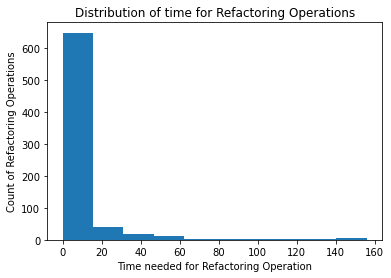

In [19]:
plt.hist(main_df['refactoring_perc_time_taken'])
plt.ylabel('Count of Refactoring Operations')
plt.xlabel('Time needed for Refactoring Operation')
plt.title('Distribution of time for Refactoring Operations')

Text(0.5, 1.0, 'Distribution of ln(time) for Refactoring Operations')

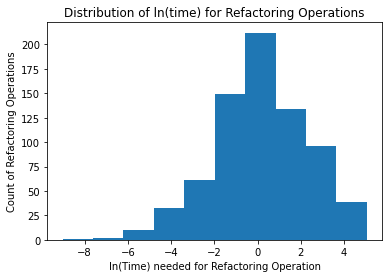

In [20]:
main_df['refactoring_perc_time_taken_log'] = np.log(main_df['refactoring_perc_time_taken'])
plt.hist(main_df['refactoring_perc_time_taken_log'])
plt.ylabel('Count of Refactoring Operations')
plt.xlabel('ln(Time) needed for Refactoring Operation')
plt.title('Distribution of ln(time) for Refactoring Operations')

(array([ 1.,  0.,  0.,  0.,  1.,  0.,  1.,  0.,  1.,  2.,  5.,  2.,  8.,
         4.,  8., 13., 12., 15., 17., 17., 28., 45., 35., 41., 36., 64.,
        48., 64., 40., 39., 34., 21., 33., 28., 21., 14., 14., 10.,  5.,
        10.]),
 array([-9.02114525, -8.66937021, -8.31759518, -7.96582015, -7.61404512,
        -7.26227009, -6.91049506, -6.55872003, -6.206945  , -5.85516996,
        -5.50339493, -5.1516199 , -4.79984487, -4.44806984, -4.09629481,
        -3.74451978, -3.39274474, -3.04096971, -2.68919468, -2.33741965,
        -1.98564462, -1.63386959, -1.28209456, -0.93031953, -0.57854449,
        -0.22676946,  0.12500557,  0.4767806 ,  0.82855563,  1.18033066,
         1.53210569,  1.88388073,  2.23565576,  2.58743079,  2.93920582,
         3.29098085,  3.64275588,  3.99453091,  4.34630594,  4.69808098,
         5.04985601]),
 <a list of 40 Patch objects>)

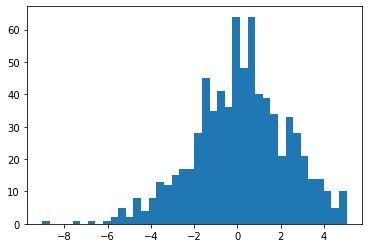

In [21]:
plt.hist(main_df['refactoring_perc_time_taken_log'],bins=40)

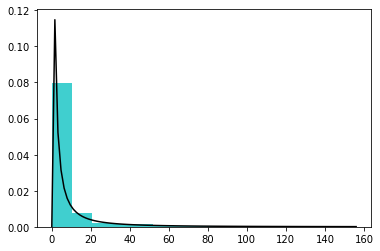

In [22]:
s, loc, scale = sp.stats.lognorm.fit(main_df['refactoring_perc_time_taken'], floc=0)
estimated_mu = np.log(scale)
estimated_sigma = s


plt.hist(main_df['refactoring_perc_time_taken'], bins=15, density=True, color='c', alpha=0.75)
xmin = main_df['refactoring_perc_time_taken'].min()
xmin = 0
xmax = main_df['refactoring_perc_time_taken'].max()
x = np.linspace(xmin, xmax, 100)
pdf = sp.stats.lognorm.pdf(x, s, scale=scale)
plt.plot(x, pdf, 'k')

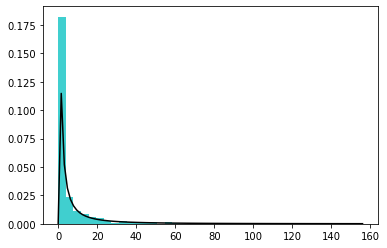

In [23]:
s, loc, scale = sp.stats.lognorm.fit(main_df['refactoring_perc_time_taken'], floc=0)
estimated_mu = np.log(scale)
estimated_sigma = s


plt.hist(main_df['refactoring_perc_time_taken'], bins=40, density=True, color='c', alpha=0.75)
xmin = main_df['refactoring_perc_time_taken'].min()
xmin = 0
xmax = main_df['refactoring_perc_time_taken'].max()
x = np.linspace(xmin, xmax, 100)
pdf = sp.stats.lognorm.pdf(x, s, scale=scale)
plt.plot(x, pdf, 'k')

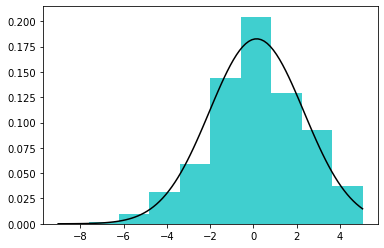

In [24]:
logdata = np.log(main_df['refactoring_perc_time_taken'])
plt.hist(logdata, bins=10, density=True, color='c', alpha=0.75)
xmin = logdata.min()
xmax = logdata.max()
x = np.linspace(xmin, xmax, 100)
pdf = sp.stats.norm.pdf(x, loc=estimated_mu, scale=estimated_sigma)
plt.plot(x, pdf, 'k')

In [25]:
len(main_df)

737

In [26]:
main_df.to_csv('test_effort_model.csv', index=False)

## EDA (Run only if absolutely necessary on minimum features)

In [27]:
#from pandas_profiling import ProfileReport

#profile = ProfileReport(main_df, title="Pandas Profiling Report",explorative=True)
#profile

In [28]:
for columns in main_df.columns:
    print(columns)

kmean_label
time_taken_mean
time_taken_min
time_taken_max
time_taken_q10
time_taken_q20
time_taken_q25
time_taken_q30
time_taken_q40
time_taken_q50
time_taken_q60
time_taken_q70
time_taken_q75
time_taken_q80
time_taken_q90
sha
name
email
date
login
message
parent_sha
parent_date
time_taken
contains_refactoring
project_name
commit_compared_with
cbo_mean
cbo_min
cbo_max
cbo_std
wmc_mean
wmc_min
wmc_max
wmc_std
dit_mean
dit_min
dit_max
dit_std
rfc_mean
rfc_min
rfc_max
rfc_std
lcom_mean
lcom_min
lcom_max
lcom_std
totalMethods_mean
totalMethods_min
totalMethods_max
totalMethods_std
staticMethods_mean
staticMethods_min
staticMethods_max
staticMethods_std
publicMethods_mean
publicMethods_min
publicMethods_max
publicMethods_std
privateMethods_mean
privateMethods_min
privateMethods_max
privateMethods_std
protectedMethods_mean
protectedMethods_min
protectedMethods_max
protectedMethods_std
defaultMethods_mean
defaultMethods_min
defaultMethods_max
defaultMethods_std
abstractMethods_mean
abstractMe

### Only taking mean for num_dependency and num_line_affected since there is only one

In [29]:
final_col = []
column_to_skip = ['sha',
'name','email','login',
'date','message',
'parent_sha','parent_date',
'time_taken','contains_refactoring',
'kmean_label','time_taken_mean',
'time_taken_min',
'time_taken_max',
'time_taken_q10',
'time_taken_q20',
'time_taken_q25',
'time_taken_q30',
'time_taken_q40',
'time_taken_q50',
'time_taken_q60',
'time_taken_q70',
'time_taken_q75',
'time_taken_q80',
'time_taken_q90',
'project_name','commit_compared_with',
'actual_num_of_classes_touched_mean',
 'actual_num_of_classes_touched_min',
 'actual_num_of_classes_touched_max',
 'actual_num_of_classes_touched_std',
'num_dependency_min',
'num_dependency_max',
'num_dependency_std',
'num_line_affected_min',
'num_line_affected_max',
'num_line_affected_std', 'time_taken_final',
'commit_line_changed',
'refactoring_perc',
# 'cocomoII_time_taken',
#'geneticP_time_taken',
#'softwareMaintenance_time_taken',
#'fuzzy_time_taken',
'time_taken_final',
'refactoring_perc_time_taken'
 ]
for element in main_df.columns:
    #print("'" + element + "',")
    if element not in column_to_skip:
        final_col.append(element)

In [30]:
final_col

['cbo_mean',
 'cbo_min',
 'cbo_max',
 'cbo_std',
 'wmc_mean',
 'wmc_min',
 'wmc_max',
 'wmc_std',
 'dit_mean',
 'dit_min',
 'dit_max',
 'dit_std',
 'rfc_mean',
 'rfc_min',
 'rfc_max',
 'rfc_std',
 'lcom_mean',
 'lcom_min',
 'lcom_max',
 'lcom_std',
 'totalMethods_mean',
 'totalMethods_min',
 'totalMethods_max',
 'totalMethods_std',
 'staticMethods_mean',
 'staticMethods_min',
 'staticMethods_max',
 'staticMethods_std',
 'publicMethods_mean',
 'publicMethods_min',
 'publicMethods_max',
 'publicMethods_std',
 'privateMethods_mean',
 'privateMethods_min',
 'privateMethods_max',
 'privateMethods_std',
 'protectedMethods_mean',
 'protectedMethods_min',
 'protectedMethods_max',
 'protectedMethods_std',
 'defaultMethods_mean',
 'defaultMethods_min',
 'defaultMethods_max',
 'defaultMethods_std',
 'abstractMethods_mean',
 'abstractMethods_min',
 'abstractMethods_max',
 'abstractMethods_std',
 'finalMethods_mean',
 'finalMethods_min',
 'finalMethods_max',
 'finalMethods_std',
 'synchronizedMetho

In [31]:
X_col = final_col.copy()
X_col.remove('refactoring_perc_time_taken_log')
Y_col = ['refactoring_perc_time_taken_log']

X = main_df[X_col]
y = main_df[Y_col]
final_df = main_df[final_col]

In [32]:
X.head()

,cbo_mean,cbo_min,cbo_max,cbo_std,wmc_mean,wmc_min,wmc_max,wmc_std,dit_mean,dit_min,...,modifiers_mean,modifiers_min,modifiers_max,modifiers_std,num_dependency_mean,num_line_affected_mean,cocomoII_time_taken,geneticP_time_taken,softwareMaintenance_time_taken,fuzzy_time_taken
0,11.000000,11.0,11.0,0.000000,8.000000,8.0,8.0,0.000000,2.000000,2.0,...,17.000000,17.0,17.0,0.000000,85.000000,61.000000,4.13952,2.477916,12.48,42.435515
1,12.000000,12.0,12.0,0.000000,8.000000,8.0,8.0,0.000000,1.000000,1.0,...,17.000000,17.0,17.0,0.000000,3.000000,78.000000,179.03424,107.076009,2229.76,519.589347
2,30.000000,30.0,30.0,0.000000,29.000000,29.0,29.0,0.000000,1.000000,1.0,...,1.000000,1.0,1.0,0.000000,78.000000,322.000000,18.11040,10.840124,189.60,113.234791
3,23.250000,5.0,63.0,20.780782,20.666667,4.0,64.0,21.993112,2.000000,1.0,...,1.000000,1.0,1.0,0.000000,57.583333,222.666667,100.38336,60.060503,1232.64,353.641141
4,7.833333,0.0,31.0,11.027514,7.833333,1.0,21.0,7.444746,1.166667,1.0,...,10.333333,1.0,17.0,8.238858,54.333333,88.000000,1002.79872,597.273303,12673.28,1634.048307


In [33]:
y.head()

,refactoring_perc_time_taken_log
0,2.708050
1,-1.489730
2,0.000000
3,1.311393
4,-4.391358


## Feature Engineering

In [34]:
h2o.init(nthreads=4)

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 12.0.1+12, mixed mode, sharing)
  Starting server from C:\ProgramData\Anaconda3\lib\site-packages\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\tanji\AppData\Local\Temp\tmp29pgmd4b
  JVM stdout: C:\Users\tanji\AppData\Local\Temp\tmp29pgmd4b\h2o_tanji_started_from_python.out
  JVM stderr: C:\Users\tanji\AppData\Local\Temp\tmp29pgmd4b\h2o_tanji_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Asia/Kuala_Lumpur
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.32.1.7
H2O_cluster_version_age:,6 months and 14 days !!!
H2O_cluster_name:,H2O_from_python_tanji_qyru7y
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,7.984 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"accepting new members, healthy"


In [35]:
from h2o.automl import H2OAutoML

full = h2o.H2OFrame(final_df)
train,test = full.split_frame(ratios=[.8], seed=16)


x = final_col
y = "refactoring_perc_time_taken_log"
x.remove(y)



Parse progress: |█████████████████████████████████████████████████████████| 100%


In [36]:
full.shape

(737, 167)

In [37]:
train[x].types

{'cbo_mean': 'real',
 'cbo_min': 'int',
 'cbo_max': 'int',
 'cbo_std': 'real',
 'wmc_mean': 'real',
 'wmc_min': 'int',
 'wmc_max': 'int',
 'wmc_std': 'real',
 'dit_mean': 'real',
 'dit_min': 'int',
 'dit_max': 'int',
 'dit_std': 'real',
 'rfc_mean': 'real',
 'rfc_min': 'int',
 'rfc_max': 'int',
 'rfc_std': 'real',
 'lcom_mean': 'real',
 'lcom_min': 'int',
 'lcom_max': 'int',
 'lcom_std': 'real',
 'totalMethods_mean': 'real',
 'totalMethods_min': 'int',
 'totalMethods_max': 'int',
 'totalMethods_std': 'real',
 'staticMethods_mean': 'real',
 'staticMethods_min': 'int',
 'staticMethods_max': 'int',
 'staticMethods_std': 'real',
 'publicMethods_mean': 'real',
 'publicMethods_min': 'int',
 'publicMethods_max': 'int',
 'publicMethods_std': 'real',
 'privateMethods_mean': 'real',
 'privateMethods_min': 'int',
 'privateMethods_max': 'int',
 'privateMethods_std': 'real',
 'protectedMethods_mean': 'real',
 'protectedMethods_min': 'int',
 'protectedMethods_max': 'int',
 'protectedMethods_std': 'r

In [38]:
train[y].types

{'refactoring_perc_time_taken_log': 'real'}

In [39]:
model_path = "models/EffortEstimationModelv3/Log_Regression_GBM_grid__1_AutoML_20220228_154246_model_3"
model = h2o.load_model(model_path)

In [40]:
model

Model Details
H2OGradientBoostingEstimator :  Gradient Boosting Machine
Model Key:  GBM_grid__1_AutoML_20220228_154246_model_3


Model Summary: 


,,number_of_trees,number_of_internal_trees,model_size_in_bytes,min_depth,max_depth,mean_depth,min_leaves,max_leaves,mean_leaves
0,,33.0,33.0,3454.0,2.0,3.0,2.575757,3.0,4.0,3.666667




ModelMetricsRegression: gbm
** Reported on train data. **

MSE: 3.2044038310962666
RMSE: 1.7900848670094573
MAE: 1.424412915308594
RMSLE: NaN
Mean Residual Deviance: 3.2044038310962666

ModelMetricsRegression: gbm
** Reported on cross-validation data. **

MSE: 3.8037588457541194
RMSE: 1.9503227542522594
MAE: 1.5519355816853435
RMSLE: NaN
Mean Residual Deviance: 3.8037588457541194

Cross-Validation Metrics Summary: 


,,mean,sd,cv_1_valid,cv_2_valid,cv_3_valid,cv_4_valid,cv_5_valid
0,mae,1.5520502,0.08237011,1.4910178,1.467426,1.6308649,1.5229915,1.647951
1,mean_residual_deviance,3.80427,0.3442388,3.4929738,3.5808723,4.040876,3.6165812,4.2900476
2,mse,3.80427,0.3442388,3.4929738,3.5808723,4.040876,3.6165812,4.2900476
3,r2,0.17276023,0.03720194,0.19935311,0.19155143,0.121441506,0.20593041,0.14552468
4,residual_deviance,3.80427,0.3442388,3.4929738,3.5808723,4.040876,3.6165812,4.2900476
5,rmse,1.9488872,0.08738271,1.8689499,1.8923193,2.0101929,1.9017311,2.071243
6,rmsle,NaN,0.0,NaN,NaN,NaN,NaN,NaN



Scoring History: 


,,timestamp,duration,number_of_trees,training_rmse,training_mae,training_deviance
0,,2022-02-28 15:43:08,1.653 sec,0.0,2.146777,1.667285,4.608652
1,,2022-02-28 15:43:08,1.673 sec,5.0,2.014709,1.580553,4.059051
2,,2022-02-28 15:43:08,1.693 sec,10.0,1.932624,1.522236,3.735036
3,,2022-02-28 15:43:08,1.717 sec,15.0,1.881267,1.490755,3.539164
4,,2022-02-28 15:43:08,1.742 sec,20.0,1.851262,1.472042,3.427170
5,,2022-02-28 15:43:08,1.771 sec,25.0,1.823754,1.451458,3.326080
6,,2022-02-28 15:43:08,1.792 sec,30.0,1.801777,1.435145,3.246400
7,,2022-02-28 15:43:08,1.805 sec,33.0,1.790085,1.424413,3.204404



Variable Importances: 


,variable,relative_importance,scaled_importance,percentage
0,uniqueWordsQty_min,1156.941528,1.000000,0.268673
1,loc_min,555.740234,0.480353,0.129058
2,cbo_std,502.424957,0.434270,0.116676
3,privateFields_std,247.563660,0.213981,0.057491
4,finalFields_std,219.819809,0.190001,0.051048
5,nosi_min,205.712997,0.177808,0.047772
6,staticFields_mean,192.080521,0.166024,0.044606
7,nosi_mean,106.552544,0.092098,0.024744
8,subClassesQty_mean,103.979286,0.089874,0.024147
9,finalFields_mean,102.416138,0.088523,0.023784



See the whole table with table.as_data_frame()


In [41]:
preds = model.predict(test)

gbm prediction progress: |████████████████████████████████████████████████| 100%


In [42]:
preds.shape

(154, 1)

In [43]:
preds.head(15)

predict
1.18545
1.87047
-0.609796
1.43915
-0.709079
1.72772
1.59848
1.70068
0.745384
-0.913319


In [44]:
preds['actual_time_taken'] = test['refactoring_perc_time_taken_log']
preds['cocomoII_time_taken'] = test['cocomoII_time_taken']
preds['geneticP_time_taken'] = test['geneticP_time_taken']
preds['softwareMaintenance_time_taken'] = test['softwareMaintenance_time_taken']
preds['fuzzy_time_taken'] = test['fuzzy_time_taken']


In [45]:
preds.head()

predict,actual_time_taken,cocomoII_time_taken,geneticP_time_taken,softwareMaintenance_time_taken,fuzzy_time_taken
1.18545,-0.144761,191.97,114.805,2393.76,544.262
1.87047,1.56582,247.336,147.875,3095.68,644.161
-0.609796,1.22223,39.3254,23.5361,458.56,189.634
1.43915,2.0149,88.9997,53.2526,1088.32,326.438
-0.709079,-0.370219,115.389,69.0334,1422.88,387.969
1.72772,2.27421,86.9299,52.0147,1062.08,321.37
1.59848,2.04307,144.883,86.6659,1796.8,451.372
1.70068,3.2062,149.54,89.4495,1855.84,460.969
0.745384,2.67809,99.3485,59.4416,1219.52,351.212
-0.913319,-3.67739,1657.36,983.883,20971.7,2282.29


In [46]:
preds.types

{'predict': 'real',
 'actual_time_taken': 'real',
 'cocomoII_time_taken': 'real',
 'geneticP_time_taken': 'real',
 'softwareMaintenance_time_taken': 'real',
 'fuzzy_time_taken': 'real'}

In [47]:
pd_preds_read_model = preds.as_data_frame()
pd_preds_read_model['actual_time_taken_raw_value'] = np.exp(pd_preds_read_model['actual_time_taken'])
pd_preds_read_model['predict_time_taken_raw_value'] = np.exp(pd_preds_read_model['predict'])

In [48]:
pd_preds_read_model.head(10)

,predict,actual_time_taken,cocomoII_time_taken,geneticP_time_taken,softwareMaintenance_time_taken,fuzzy_time_taken,actual_time_taken_raw_value,predict_time_taken_raw_value
0,1.185453,-0.144761,191.97024,114.805271,2393.76,544.262337,0.865229,3.272170
1,1.870472,1.565823,247.33632,147.875178,3095.68,644.160639,4.786611,6.491356
2,-0.609796,1.222226,39.32544,23.536054,458.56,189.633767,3.394737,0.543462
3,1.439150,2.014903,88.99968,53.252555,1088.32,326.438257,7.500000,4.217109
4,-0.709079,-0.370219,115.38912,69.033430,1422.88,387.969305,0.690583,0.492097
5,1.727721,2.274210,86.92992,52.014663,1062.08,321.369979,9.720238,5.627813
6,1.598481,2.043074,144.88320,86.665937,1796.80,451.372113,7.714286,4.945516
7,1.700679,3.206201,149.54016,89.449540,1855.84,460.968976,24.685121,5.477665
8,0.745384,2.678092,99.34848,59.441631,1219.52,351.212488,14.557292,2.107250
9,-0.913319,-3.677394,1657.36032,983.882551,20971.68,2282.285635,0.025289,0.401190


In [49]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error, mean_absolute_error


print(r2_score(pd_preds_read_model['actual_time_taken'], pd_preds_read_model['predict']))
print(r2_score(np.exp(pd_preds_read_model['actual_time_taken']), np.exp(pd_preds_read_model['predict'])))
print(mean_squared_error(pd_preds_read_model['actual_time_taken'], pd_preds_read_model['predict'],squared=False))
print(mean_squared_error(np.exp(pd_preds_read_model['actual_time_taken']), np.exp(pd_preds_read_model['predict']),squared=False))
print(mean_squared_error(np.exp(pd_preds_read_model['actual_time_taken']), np.exp(pd_preds_read_model['predict'])))

print(mean_squared_error(pd_preds_read_model['actual_time_taken_raw_value'], pd_preds_read_model['predict_time_taken_raw_value'], squared=False))
print(mean_absolute_error(pd_preds_read_model['actual_time_taken_raw_value'], pd_preds_read_model['predict_time_taken_raw_value']))

0.2659565181450615
-0.022268789833443492
1.9671359300646738
15.381629939115845
236.59453958390492
15.381629939115845
5.46845042149721


In [50]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error


print(r2_score(np.exp(pd_preds_read_model['actual_time_taken']), pd_preds_read_model['cocomoII_time_taken']))
print(mean_squared_error(np.exp(pd_preds_read_model['actual_time_taken']), pd_preds_read_model['cocomoII_time_taken'],squared=False))
print(mean_squared_error(pd_preds_read_model['actual_time_taken_raw_value'], pd_preds_read_model['cocomoII_time_taken'],squared=False))
print(mean_absolute_error(pd_preds_read_model['actual_time_taken_raw_value'], pd_preds_read_model['cocomoII_time_taken']))

-116903.00648303612
5201.570694669999
5201.570694669999
893.2239385139932


In [51]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error


print(r2_score(np.exp(pd_preds_read_model['actual_time_taken']), pd_preds_read_model['geneticP_time_taken']))
print(mean_squared_error(np.exp(pd_preds_read_model['actual_time_taken']), pd_preds_read_model['geneticP_time_taken'],squared=False))
print(mean_absolute_error(np.exp(pd_preds_read_model['actual_time_taken']), pd_preds_read_model['geneticP_time_taken']))

-21469.500146156683
2229.158187255114
453.30661464914954


In [52]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error


print(r2_score(np.exp(pd_preds_read_model['actual_time_taken']), pd_preds_read_model['softwareMaintenance_time_taken']))
print(mean_squared_error(np.exp(pd_preds_read_model['actual_time_taken']), pd_preds_read_model['softwareMaintenance_time_taken'],squared=False))
print(mean_absolute_error(np.exp(pd_preds_read_model['actual_time_taken']), pd_preds_read_model['softwareMaintenance_time_taken']))

-18786447.69865558
65938.969114608
11310.716445526981


In [53]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error


print(r2_score(np.exp(pd_preds_read_model['actual_time_taken']), pd_preds_read_model['fuzzy_time_taken']))
print(mean_squared_error(np.exp(pd_preds_read_model['actual_time_taken']), pd_preds_read_model['fuzzy_time_taken'],squared=False))
print(mean_absolute_error(np.exp(pd_preds_read_model['actual_time_taken']), pd_preds_read_model['fuzzy_time_taken']))

-25722.63670019171
2439.9784539596817
932.2365823953867


Text(0.5, 1.0, 'Predicted vs Actual')

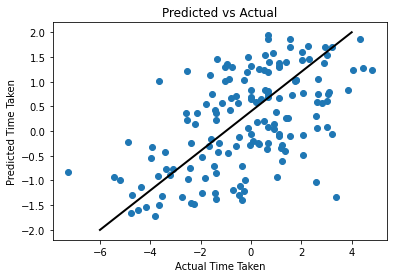

In [54]:
import matplotlib.pyplot as plt
plt.scatter(pd_preds_read_model['actual_time_taken'], pd_preds_read_model['predict'])
point1 = [-6, -2]
point2 = [4, 2]
#point1 = [-4,-4]
#point2 = [4,4]

x_values = [point1[0], point2[0]]
y_values = [point1[1], point2[1]]
plt.plot(x_values, y_values, color = 'black', linewidth = 2)
plt.xlabel('Actual Time Taken')
plt.ylabel('Predicted Time Taken')
plt.title('Predicted vs Actual')